### pip install & import

In [56]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
#import pandas_profiling
import datetime

In [57]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

# from xgboost import XGBRFRegressor
from sklearn.model_selection import cross_validate

### 최종데이터 불러오기

In [58]:
movie_final = pd.read_csv('../3_merge_top300/movie_final.csv',encoding='utf-8')

## 원핫인코딩 

In [ ]:
# 원핫인코딩

# movie_labels = pd.get_dummies(movie_final,columns = ['국적','장르','등급','계절'])

In [ ]:
# 독립 변수와 종속 변수 나눔

# 독립 = movie_DL[['감독_흥행', '배급사_흥행', '국적_기타', '국적_독일', '국적_미국',
#        '국적_영국', '국적_일본', '국적_중국', '국적_프랑스', '국적_한국', '장르_SF', '장르_가족', '장르_공연',
#        '장르_공포(호러)', '장르_기타', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_뮤지컬',
#        '장르_미스터리', '장르_범죄', '장르_사극', '장르_서부극(웨스턴)', '장르_성인물(에로)', '장르_스릴러',
#        '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_전쟁', '장르_코미디', '장르_판타지',
#        '등급_12세관람가', '등급_15세관람가', '등급_전체관람가', '등급_청소년관람불가', '계절_가을', '계절_겨울',
#        '계절_봄', '계절_여름']] 
# 종속 = movie_DL[['전국 관객수']] 

## 라벨링

In [59]:
from sklearn.preprocessing import LabelEncoder

le_form = LabelEncoder()
le_nation = LabelEncoder()
le_genre = LabelEncoder()
le_rating = LabelEncoder()
le_class = LabelEncoder()
le_season = LabelEncoder()

movie_labels = movie_final.copy()
movie_labels['영화형태'] = le_form.fit_transform(movie_final['영화형태'])
movie_labels['국적'] = le_nation.fit_transform(movie_final['국적'])
movie_labels['장르'] = le_genre.fit_transform(movie_final['장르'])
movie_labels['등급'] = le_rating.fit_transform(movie_final['등급'])
movie_labels['영화구분'] = le_class.fit_transform(movie_final['영화구분'])
movie_labels['계절'] = le_season.fit_transform(movie_final['계절'])
movie_labels.drop(['Unnamed: 0'],axis=1,inplace=True)
movie_labels.head(3)


,순번,영화명,감독,배급사,개봉일,영화형태,국적,전국 스크린수,전국 매출액,전국 관객수,...,영화구분,연도,월,계절,총 관객수,출연,평점,감독_흥행,배급사_흥행,주연배우_흥행
0,25,아바타: 물의 길,제임스 카메론,월트디즈니스튜디오스코리아,2022-12-14,2,2,2809,137325939643,10779198,...,1,2022,12,1,112805094,"['시고니 위버', '스티븐 랭', '조 샐다나', '샘 워싱턴', '우나 채플린'...",8.65,0,10,10
1,26,어벤져스: 에이지 오브 울트론,조스 웨던,월트디즈니스튜디오스코리아,2015-04-23,2,2,1843,88582586366,10494499,...,1,2015,4,2,217299523,"['로버트 다우니 주니어', '크리스 헴스워스', '마크 러팔로', '크리스 에반스...",8.32,9,10,76
2,27,기생충,봉준호,씨제이이엔엠,2019-05-30,2,7,1948,87459829095,10313086,...,1,2019,5,2,226678777,"['송강호', '이선균', '조여정', '최우식', '박소담', '이정은', '장혜진']",8.49,10,10,26


### 데이터분배
1) movie_labels_etc : train과 val data   
2) movie_labels_2023 : test data

In [60]:
movie_labels_2023 = movie_labels[movie_labels['연도']==2023]
movie_labels_etc = movie_labels[movie_labels['연도']!=2023]

### 변수 정리   
1. 사용하지 않는 컬럼 제거
2. 독립변수와 종속변수 설정

In [61]:
# 사용하지 않는 컬럼 제거

not_used = ['영화명', '감독', '배급사', '영화형태', '개봉일', '영화구분', '연도', '월']

movie_DL = movie_labels_etc.drop(not_used, axis=1) # 2003~2022 데이터 main
movie_DL2 = movie_labels_2023.drop(not_used, axis=1)# 2023년 test


In [ ]:
# 국적 => 국내 vs 해외
# 관객비율.. 2023년 데이터 총 관객수 몰라....
# 비율 말고 총 관객수를 쓰자
# 총관객수 defqult를 2022년으로 해서 2023년 총관객수 채우면 어때?

## 데이터를 (train, test) 나누기 (연도 기준)

In [62]:
종속 = movie_DL[['전국 관객수']].copy()
종속['전국 관객수'] = 종속['전국 관객수'] / 1000

종속_2023 = movie_DL2[['전국 관객수']].copy()
종속_2023['전국 관객수'] = 종속_2023['전국 관객수'] / 1000

독립 = movie_DL[['국적','장르', '등급', '감독_흥행','총 관객수',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수']].copy()
독립['총 관객수'] = 독립['총 관객수'] / 1000

독립_2023 = movie_DL2[['국적','장르', '등급', '감독_흥행','총 관객수',
               '배급사_흥행','주연배우_흥행','계절', '전국 스크린수']].copy()
독립_2023['총 관객수'] = 독립_2023['총 관객수'] / 1000

## train -> (train(훈련용), val(검증용))로 나누기 (random)

In [63]:
# train, test 데이터 나눔

from sklearn.model_selection import train_test_split
train_input, test_input, train_target,test_target = train_test_split(독립,종속,test_size=0.25,random_state=42)

## 스케일링... 
...어디서 할까...<br>
라벨링 때문에 바로 스케일링을 따로 해줘야함 (전국스크린수, 전국매출액)

In [ ]:
# # 값 스케일링

# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# ss.fit(train_input)
# train_scaled = ss.transform(train_input)
# test_scaled = ss.transform(test_input)

# 딥러닝 


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#%pip install -q -U keras_tuner
#설치하고 커널 리스타트 (안하면 에러남))
#import kerastuner as kt

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

##### hyperparameter tuner 

In [ ]:
class MyHyperModel(kt.HyperModel):
  def build(self, hp):
    # units_1 => 뉴런의 개수를 조정하는 부분 
    # dropout_1 => 
    hp_units1 = hp.Int('units_1', min_value = 16, max_value = 180)
    hp_units2 = hp.Int('units_2', min_value = 16, max_value = 180)
    hp_units4 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.05)
    hp_units5 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.05)

    # 현재 레이어 층은 입력층 > 히든층 > 출력층
    model = keras.Sequential()
    # 입력층
    model.add(layers.Dense(hp_units1, activation='swish', input_shape=[9]))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp_units4))
    # 히든층
    model.add(layers.Dense(hp_units2, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp_units5))
    # 출력층
    model.add(layers.Dense(1, activation='softmax'))


    # 1. learning rate 범위설정 
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG')
    # 옵티마이저 설정 
    # choice를 통해 값을 선택에서 받음 
    # hp.int을 쓰면 정수값, hp.float를 쓰면 소수값, hp.choice를 쓰면 선택해서

    #Adam
    Adam = optimizers.Adam(leanring_rate=hp_learning_rate, beta_1=hp.Choice('beta_1', [.9, .8, .7, .6, .5]), beta_2=hp.Choice('beta_2', [.99, .88, .77, .66, .55]))

    #SGD 
    SGD = optimizers.SGD(learning_rate=hp_learning_rate, momentum=hp.Choice('momentum',[9,8,7,6,5]))
    #나머지 추가해야함
    
    model.compile(optimizer=Adam,oss='mae')
    return model
  # 배치사이즈 설정 
  def fit(self, hp, model, *args, **kwargs):
      return model.fit(
          *args,
          batch_size=hp.Int('batch_size', min_value = 16, max_value = 256, step = 16),
          **kwargs,
      )

In [ ]:
tuner = kt.Hyperband(MyHyperModel(),
                    objective = 'loss',
                    max_epochs = 100,
                    executions_per_trial = 3,
                    overwrite = True,
                    factor = 3)
tuner.search(train_input,train_target, epochs = 100, validation_split = 0.1)

In [ ]:
# 최적 하이퍼파라미터를 가져옵니다.
best_hps = tuner.get_best_hyperparameters()[0]
# 최적 하이퍼파라미터를 출력합니다.
print(f"""
units_1 : {best_hps.get('units_1')}
units_2 : {best_hps.get('units_2')}
dropout_1 : {best_hps.get('dropout_1')}
dropout_2 : {best_hps.get('dropout_2')}
learning_rate : {best_hps.get('learning_rate')}
batch_size : {best_hps.get('batch_size')}
momentum : {best_hps.get('momentum')}
""")

In [ ]:
# 배치 크기는 따로 저장했다가 fit 메소드에서 적용합니다.
batch_size = best_hps.get('batch_size')
# 최적값으로 모델을 생성합니다.
model = tuner.hypermodel.build(best_hps)

##### ---

# 딥러닝 열심히 돌려보기 

In [66]:
# 딥러닝 층 여기가 중요

X = tf.keras.layers.Input(shape=[len(독립.columns)] )

H = tf.keras.layers.Dense(100)(X)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.relu6)(H)

H = tf.keras.layers.Dense(90)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.relu6)(H)

H = tf.keras.layers.Dense(80)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.relu6)(H)

H = tf.keras.layers.Dense(70)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.relu6)(H)

H = tf.keras.layers.Dense(128)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.relu6)(H)

H = tf.keras.layers.Dense(128)(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation(tf.nn.relu6)(H)
dropout = tf.keras.layers.Dropout(rate=0.3)(H)

Y = tf.keras.layers.Dense(1)(dropout)

model = tf.keras.models.Model(X,Y)
sgd = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
# sgd = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.7)
# sgd = tf.keras.optimizers.Nadam(learning_rate=0.01,beta_1=0.8,beta_2=0.85)
model.compile(optimizer=sgd,loss='mae')

---

In [69]:
# 훈련
history =model.fit(train_input,train_target,batch_size=128,epochs=200,validation_data=(test_input,test_target))

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 335.0022

IndexError: tuple index out of range

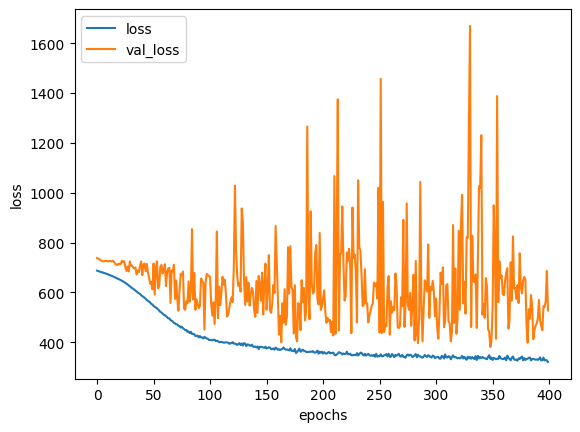

In [68]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [70]:
# 확인용도
model.predict(train_input[:5])

2023-03-31 15:59:43.620867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 753ms/step


array([[297.9326  ],
       [ 69.59788 ],
       [ 17.008657],
       [891.9237  ],
       [637.3909  ]], dtype=float32)

In [71]:
# 여기랑 비슷한지 보기
train_target[:5]

,전국 관객수
2365,31.022
2711,18.241
3041,10.859
544,1125.739
789,618.598


In [72]:
종속_2023[:]

,전국 관객수
378,1720.865
465,1376.493
670,829.268
755,663.836
1009,398.964
1071,346.265
1188,274.283
1240,241.148
1265,229.558
1355,198.100


### test data 확인용도

In [73]:
# 확인용도

# 오차율 몇 %로...?
pred = model.predict(독립_2023).round(0)
# 여기랑 비슷한지 보기
종속_2023['pred'] = pred
종속_2023['오차율'] = (abs(종속_2023['전국 관객수'] - 종속_2023['pred'])) / 종속_2023['전국 관객수'] * 100
len(종속_2023.loc[종속_2023['오차율']>20])

1/1 [==============================] - 0s 179ms/step


27